### About this Project:

This Project aims to analyze News Articles using NLP techniques, to qunatify about how a particular news is potrayed by differet media houses.
Ultimatly aiming to understand if there are any biases.

#### What is Bias?
- Inclination or prejudice for or against one person or group, especially in a way considered to be unfair.

#### Challenges:
Its is hard to define what is considered as bias quantitatively as there are multiple qualitative factors involved.

#### Project Flow
- Extract Meta Data from Google News Search results
- Using the URLs in the Meta Data extract News Article Text and other related information using News3k package.
- Preprocess the text information and other features.
- Use pretrained Models to understand the Over all sentiment of the Article and how Sentiment Changes from start to end of the article.
- Use pretrained Models to understand the Over all emotion of the Article and how emotion Changes from start to end of the article.
- Extract Other textual features.
- Do Clustering of the articles.
- Identify the what features contribute to the Cluster formations.
- Future Work



### Importing Required Packages

In [40]:
# Data Processing
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import datetime
import numpy as np
import re
import ast
import time
import string
import neattext as nt
from textblob import TextBlob
import re
from collections import Counter

#Data Extraction
from GoogleNews import GoogleNews
from newspaper import Article
from newspaper import Config

#Analysis
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


#Visulization
import plotly.express as px

#Models
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelWithLMHead

#Others
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/balajisrirajduraisamyushamala/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/balajisrirajduraisamyushamala/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/balajisrirajduraisamyushamala/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Extract Dataset

#### Configuration

In [17]:
#config will allow us to access the specified url for which we are #not authorized. Sometimes we may get 403 client error while parsing #the link to download the article.
user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
config = Config()
config.browser_user_agent = user_agent
config.request_timeout = 15

#Search Configurations
region = 'IN'
start_date =  datetime.date(2023, 1, 24)  #MM/DD/YYYY #datetime.date(2022, 1, 25)'01/24/2023'
end_date =  datetime.date(2023, 3, 31)
no_of_days_from_start_date = end_date - start_date
no_of_days_from_start_date = no_of_days_from_start_date.days
interval_days = 3
periods = round(no_of_days_from_start_date/interval_days)

search_string = 'Adani'
lang='en'
region='IN'
no_of_pages = 3
sleep_time = 20.0

#### Extract Meta Data

In [ ]:
# Contains the final results = news filtered by the criteria 
# (news that in their description contains the search term).
final_results = []
# Initial list of results - it will contain a list of dictionaries (dict).
results = []
for period in tqdm(range(1,periods+1)):
        #Creating Dynamic Date Ranges
        if period == 1:
            dynamic_end_date = start_date+datetime.timedelta(days=interval_days)
            dynamic_start_date = start_date
        else:
            dynamic_start_date = dynamic_end_date+datetime.timedelta(days=1)
            dynamic_end_date = dynamic_start_date+datetime.timedelta(days=interval_days)
        print(f'Getting News for the period {dynamic_start_date} to {dynamic_end_date}')
        googlenews=GoogleNews(start=str(dynamic_start_date.strftime("%m/%d/%Y")),end=str(dynamic_end_date.strftime("%m/%d/%Y")),lang=lang, region=region) # I suppose the date is in "MM/dd/yyyy" format...
        googlenews.search(search_string)
        
    # Get first x pages with the results and append those results to the list - you can set any other range according to  your needs: 
        for page in range(1,no_of_pages+1):
            print(f'Getting News for the period {dynamic_start_date} to {dynamic_end_date}, Page NO : {page}')
            print('Waiting..')
            time.sleep(sleep_time) # Sleep time is set in order not to be blocked for continous searching, please reduce this to extract the data faster
            googlenews.getpage(page) # Consider add an timer for avoid multiple calls and get "HTTP Error 429: Too Many Requests" error.
            results.extend(googlenews.result(sort=True))

In [ ]:
# Remove duplicates and include to the "final_results" list 
for item in results: 
            #if (item not in final_results and (search_string in item["desc"])): # only the news that includes in their description the search term:
                final_results.append(item)
# Build and show the final dataframe: 
df=pd.DataFrame(final_results).drop_duplicates()
df.to_csv(f'./data/raw_data/Meta_data_{search_string}.csv',index=False)

#### Manual URLs

In [18]:
df_manual_meta = pd.read_csv(f'./data/raw_data/Manual_Adani Articles.csv')

In [19]:
#Combining both Extracted Meta URLs & Manual URLs
df = pd.read_csv(f'./data/raw_data/Meta_data_{search_string}.csv')
df = pd.concat([df,df_manual_meta])
df = df.drop_duplicates()

#### Extract Full Article from Meta Data's URLs

In [20]:
# Filter for only certain Media Houses
filter_list = [ 'ABP LIVE','Adani Watch','Ahmedabad Mirror','Bar and Bench','Business Today','CNBCTV18.com',
 'Daily Pioneer','Financial Times','Hindustan Times','IFR','India Today','Indian National Congress',
 'Indtoday','Live Law','Mint','NDTV.com','Onmanorama','OpIndia','Outlook India','PTI','Rediff.com',
 'Republic','Scroll','SwarajyaMag','Telangana Today','Telegraph India','The Business Times','The Economic Times',
 'The Hindu','The Hindu Business Line','The Indian Express','The Morning Context','The New Indian Express',
 'The Wire','ThePrint','Times Now','Times of India','Tribune India','Wire','Zee Business']

In [21]:
df = df[df['media'].isin(filter_list)].drop_duplicates()

In [ ]:
list = []
failed_list = []
for ind in tqdm(df.index):
    dict={}
    url = (df[df.index ==ind]['link']).to_list()[0]
    article = Article(url)
    try:
        article.download()
        article.parse()
        article.nlp()
        dict['Meta_Publisher'] = (df[df.index ==ind]['media']).to_list()[0]
        dict['Meta_datetime'] = (df[df.index ==ind]['datetime']).to_list()[0]
        dict['Meta_title'] = (df[df.index ==ind]['title']).to_list()[0]
        dict['Meta_link'] = (df[df.index ==ind]['link']).to_list()[0]
        dict['Meta_desc'] = (df[df.index ==ind]['desc']).to_list()[0]
        try:
            dict['Published_Date']=str(article.publish_date)
        except:
            dict['Published_Date']=str(article.publish_date)
        try:
            dict['Title']=article.title
        except:
            dict['Title']='NA'
        try:
            dict['Article']=article.text
        except:
            dict['Article']='NA'
        try:
            dict['Summary']=article.summary
        except:
            dict['Summary']='NA'
        try:
            dict['Authors'] = article.authors
        except:
            dict['Authors'] = 'NA'
        try:
            dict['Keywords'] = article.keywords
        except:
            dict['Keywords'] = 'NA'   
        list.append(dict)
    except:
        failed_list.append(ind)
        dict['Meta_Publisher'] = (df[df.index ==ind]['media']).to_list()[0]
        dict['Meta_datetime'] = (df[df.index ==ind]['datetime']).to_list()[0]
        dict['Meta_title'] = (df[df.index ==ind]['title']).to_list()[0]
        dict['Meta_link'] = (df[df.index ==ind]['link']).to_list()[0]
        dict['Meta_desc'] = (df[df.index ==ind]['desc']).to_list()[0]
        dict['Published_Date']=str(article.publish_date)
        dict['Title']='NA'
        dict['Article']='NA'
        dict['Summary']='NA'
        dict['Authors'] = 'NA'
        dict['Keywords'] = 'NA'
        list.append(dict)

In [ ]:
news_df=pd.DataFrame(list)
news_df.to_csv('./data/processed_data/extracted_data_new.csv',index=False)
print('Number Failed Articles : ',len(failed_list)/len(df.index),'%')

### Data Pre - Processing

In [22]:
df_raw = pd.read_csv('./data/processed_data/extracted_data_new.csv')

In [23]:
pd.DataFrame(df_raw['Meta_Publisher'].value_counts())

,Meta_Publisher
Mint,84
The Economic Times,82
Business Today,73
Times of India,34
Scroll,28
Wire,23
OpIndia,22
Financial Times,21
The Hindu,21
The Indian Express,17


In [24]:
fillna_cols = ['Title','Article','Summary','Authors','Keywords']
df_raw[fillna_cols] = df_raw[fillna_cols].fillna('NA') #Filling NA for the cols where we have null values
#Removing rows where we do not have Article text
df_raw = df_raw[df_raw['Article'] != 'NA']
df_raw.reset_index(drop = True,inplace=True)
df_raw['index'] = df_raw.index # Creating an index column
df_raw['Authors_Count'] = df_raw.Authors.transform(ast.literal_eval).str.len() # Getting number of Authors, if there are no Authors info then it would be set to 0.

In [25]:
print('Missing Data on Authors: ',df_raw[df_raw['Authors_Count']== 0].shape[0]/df_raw.shape[0])

Missing Data on Authors:  0.6728778467908902


In [26]:
authors_list = []
#Removing the list format
for authors in df_raw['Authors']:
    temp = authors[1:-1].replace("'", "")
    if temp == '':
        authors_list.append('Not Available')    
    else:
        authors_list.append(temp)
df_raw.Authors = authors_list

Remove noise
- stopwords
- special characters
- punctuations
- hashtags
- @userhandles
- extra spaces
- emails
- special chars
- & many more


In [27]:
#Text Cleaning
failed_indexs = []
for col in ['Meta_title','Meta_desc','Title','Article','Summary']:
    for ind in df_raw.index :
        try:
            sentx = nt.TextFrame(text=df_raw[col][ind])
            text = sentx.remove_hashtags()
            text = text.remove_userhandles()
            text = text.remove_bad_quotes()
            text = text.remove_emails()
            text = text.remove_currency_symbols()
            text = text.remove_dates()
            text = text.remove_phone_numbers()
            text = text.remove_multiple_spaces()
            text = text.remove_html_tags()
            text = text.remove_emojis()
            text = text.remove_emails()
            #text = text.remove_puncts()
            text = text.remove_urls()
            text = text.remove_special_characters()
            #text = text.remove_stopwords()
            text = str(text)
            text = text.replace("\n", "")
            text = text.replace("’s", "")
            df_raw[col][ind] = text
        except:
            failed_indexs.append(ind)
            pass
    print(f'Cleaning Completed for : {col}')
print('Failed Cases : ',len(failed_indexs))

Cleaning Completed for : Meta_title
Cleaning Completed for : Meta_desc
Cleaning Completed for : Title
Cleaning Completed for : Article
Cleaning Completed for : Summary
Failed Cases :  180


In [28]:
#Grouping similar media houses to same entity
df_raw.loc[df_raw['Meta_Publisher'].isin(['Wire',]),'Meta_Publisher'] = 'The Wire'

In [29]:
df_raw.to_csv('./data/processed_data/processed_data.csv',index=False)

### Using Pre-Trained Models for Sentiment & Emotion Classification

#### Sentiment Prediction - Article

In [30]:
df_raw = pd.read_csv('./data/processed_data/processed_data.csv')

In [31]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

In [32]:
#Creating Empty Columns
df_raw['sentiment_flow']  = np.nan
df_raw['sentiment_flow_score'] = np.nan

In [33]:
def get_sentiment(tokens):
    outputs = model(**tokens)
    probabilities = torch.nn.functional.softmax(outputs[0],dim = -1)

def chunk_text_to_window_size_and_predict_prob(input_ids,attention_mask,total_length,window_length):
    proba_list = []
    start = 0
    window_length = window_length

    loop =True
    while loop:
        end = start + window_length
        if end>= total_length:
            loop = False
            end = total_length
        # Define teh text chunk
        input_id_chunk = input_ids[start:end]
        attention_mask_chunk = attention_mask[start:end]

        # Append [CLS] and [SEP]
        input_id_chunk = [101] + input_id_chunk + [102]
        attention_mask_chunk = [1] + attention_mask_chunk + [1]

        # Convert type list to pytroch tensor
        input_dict = {
            'input_ids' : torch.Tensor([input_id_chunk]).long(),
            'attention_mask' : torch.Tensor([attention_mask_chunk]).int()
        }

        outputs = model(**input_dict)
        probabilities = torch.nn.functional.softmax(outputs[0],dim = -1)
        proba_list.append(probabilities)
        start = end

    return proba_list

def get_mean_from_proba(proba_list,index):
    with torch.no_grad():
        ###
        temp_sentiment = []
        temp_sentiment_score = []
        for list in proba_list:
            with torch.no_grad():
                temp_score = round(list.max().item(),2)
                temp_sentiment_score.append(temp_score)
                temp_senti = torch.argmax(list).item()
                temp_sentiment.append(temp_senti)
            df_raw['sentiment_flow'] [index] = str(temp_sentiment)
            df_raw['sentiment_flow_score'][index] = str(temp_sentiment_score)
        ###
        stacks = torch.stack(proba_list)
        stacks = stacks.resize(stacks.shape[0],stacks.shape[2])
        mean = stacks.mean(dim = 0)
        score = round(mean.max().item(),2)
        mean = torch.argmax(mean).item()
    return mean ,score

In [34]:
Article_Overall_Sentiment = []
Article_Overall_Sentiment_score = []
for index in tqdm(df_raw['index']):
    tokens = tokenizer.encode_plus( df_raw['Article'][index],add_special_tokens=False)
    input_ids = tokens['input_ids']
    attention_mask = tokens['attention_mask']
    proba_list = chunk_text_to_window_size_and_predict_prob(input_ids,attention_mask,total_length = len(input_ids),window_length = int(len(input_ids)/11))
    article_sentiment,score = get_mean_from_proba(proba_list,index)
    Article_Overall_Sentiment.append(article_sentiment)
    Article_Overall_Sentiment_score.append(score)

  0%|          | 0/483 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1123 > 512). Running this sequence through the model will result in indexing errors


In [35]:
df_raw['Article_Overall_Sentiment'] = Article_Overall_Sentiment
df_raw['Article_Overall_Sentiment_score'] = Article_Overall_Sentiment_score
replace_values = {0: "Negative",
                    1: "Neutral",
                    2: "Positive"}
df_raw['Article_Overall_Sentiment'] = df_raw['Article_Overall_Sentiment'].map(replace_values)

In [36]:
df_temp = pd.DataFrame(df_raw['sentiment_flow'].str.split().values.tolist(),columns=
             ['Article_sentiment_flow_1',
              'Article_sentiment_flow_2',
              'Article_sentiment_flow_3',
              'Article_sentiment_flow_4',
              'Article_sentiment_flow_5',
              'Article_sentiment_flow_6',
              'Article_sentiment_flow_7',
              'Article_sentiment_flow_8',
              'Article_sentiment_flow_9',
              'Article_sentiment_flow_10',
              'Article_sentiment_flow_11',
              'Article_sentiment_flow_12',
              'Article_sentiment_flow_13',
              'Article_sentiment_flow_14',
              'Article_sentiment_flow_15',
             ])
df_temp.drop(['Article_sentiment_flow_13',
              'Article_sentiment_flow_14',
              'Article_sentiment_flow_15'],axis=1,inplace=True)
#Cleaning the values
for col in df_temp.columns:
    df_temp[col] = df_temp[col].str.replace('[', '')
    df_temp[col] = df_temp[col].str.replace(']', '')
    df_temp[col] = df_temp[col].str.replace(',', '')
df_raw.drop(['sentiment_flow'],axis=1,inplace=True)
df_raw = pd.concat([df_raw,df_temp],axis=1)

In [37]:
df_temp = pd.DataFrame(df_raw['sentiment_flow_score'].str.split().values.tolist(),columns=
             ['Article_sentiment_flowscore_1',
              'Article_sentiment_flowscore_2',
              'Article_sentiment_flowscore_3',
              'Article_sentiment_flowscore_4',
              'Article_sentiment_flowscore_5',
              'Article_sentiment_flowscore_6',
              'Article_sentiment_flowscore_7',
              'Article_sentiment_flowscore_8',
              'Article_sentiment_flowscore_9',
              'Article_sentiment_flowscore_10',
              'Article_sentiment_flowscore_11',
              'Article_sentiment_flowscore_12',
              'Article_sentiment_flowscore_13',
              'Article_sentiment_flowscore_14',
              'Article_sentiment_flowscore_15',
             ])
df_temp.drop(['Article_sentiment_flowscore_13',
              'Article_sentiment_flowscore_14',
              'Article_sentiment_flowscore_15'],axis=1,inplace=True)
#Cleaning the values
for col in df_temp.columns:
    df_temp[col] = df_temp[col].str.replace('[', '')
    df_temp[col] = df_temp[col].str.replace(']', '')
    df_temp[col] = df_temp[col].str.replace(',', '')
df_raw.drop(['sentiment_flow_score'],axis=1,inplace=True)
df_raw = pd.concat([df_raw,df_temp],axis=1)

In [38]:
replace_values = {'0': "Negative",
                    '1': "Neutral",
                    '2': "Positive"}
replace_cols = ['Article_sentiment_flow_1',
       'Article_sentiment_flow_2', 'Article_sentiment_flow_3',
       'Article_sentiment_flow_4', 'Article_sentiment_flow_5',
       'Article_sentiment_flow_6', 'Article_sentiment_flow_7',
       'Article_sentiment_flow_8', 'Article_sentiment_flow_9',
       'Article_sentiment_flow_10', 'Article_sentiment_flow_11',
       'Article_sentiment_flow_12']
for col in replace_cols:
    df_raw[col] = df_raw[col].map(replace_values)

#### Sentiment Prediction - Title

In [42]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

In [43]:
#Creating Empty Columns
df_raw['sentiment_flow']  = np.nan
df_raw['sentiment_flow_score'] = np.nan

#### Sentiment Prediction - Summary

In [44]:
Title_Overall_Sentiment = []
Tile_Overall_Sentiment_score = []
for index in tqdm(df_raw['index']):
    tokens = tokenizer.encode_plus( df_raw['Title'][index],add_special_tokens=False)
    input_ids = tokens['input_ids']
    attention_mask = tokens['attention_mask']
    proba_list = chunk_text_to_window_size_and_predict_prob(input_ids,attention_mask,total_length = len(input_ids),window_length = int(len(input_ids)/1))
    Title_sentiment,score = get_mean_from_proba(proba_list,index)
    Title_Overall_Sentiment.append(Title_sentiment)
    Tile_Overall_Sentiment_score.append(score)

  0%|          | 0/483 [00:00<?, ?it/s]

In [45]:
df_raw['Title_Overall_Sentiment'] = Title_Overall_Sentiment
df_raw['Title_Overall_Sentiment_score'] = Tile_Overall_Sentiment_score
replace_values = {0: "Negative",
                    1: "Neutral",
                    2: "Positive"}
df_raw['Title_Overall_Sentiment'] = df_raw['Title_Overall_Sentiment'].map(replace_values)

In [46]:
df_raw.drop(['sentiment_flow','sentiment_flow_score'],axis = 1, inplace = True)

In [47]:
df_raw.to_csv('./data/processed_data/processed_data.csv',index=False)

In [48]:
#Analysis part - Refer later
# pd.DataFrame(df_raw['Article_Overall_Sentiment'].value_counts())/df_raw['Article_Overall_Sentiment'].count()
# pd.DataFrame(df_raw.groupby('Article_Overall_Sentiment')['Article_Overall_Sentiment_score'].mean())
# df_temp = df_raw.groupby(['Meta_Publisher','Article_Overall_Sentiment']).agg({'Article_Overall_Sentiment':'count'}).rename(columns={'Article_Overall_Sentiment':'count'}).reset_index()
# df_temp1 = df_raw.groupby(['Meta_Publisher']).agg({'Article_Overall_Sentiment':'count'}).rename(columns={'Article_Overall_Sentiment':'Overallcount'}).reset_index()
# df_temp = pd.merge(df_temp,df_temp1, on=['Meta_Publisher'],how = 'inner')
# df_temp['Percentage'] = round(df_temp['count'] / df_temp['Overallcount'] , 2)
# df_temp = df_temp.pivot_table(columns=['Article_Overall_Sentiment'], index= ['Meta_Publisher'], values=['Percentage']).fillna(0.0).reset_index()
# df_temp = df_temp.droplevel(0, axis=1)
# df_temp.columns = ['Media' ,'Negative',	'Neutral',	'Positive']
# mxs = df_temp.eq(df_temp.max(axis=1), axis=0)
# # join the column names of the max values of each row into a single string
# df_temp['Dominant'] = mxs.dot(mxs.columns + ', ').str.rstrip(', ')
# df_raw = df_raw.sort_values(['Meta_datetime','Meta_Publisher'],ascending=True).reset_index(drop=True)
# df_raw.reset_index(drop=True,inplace = True)
# df_raw['index'] = df_raw.index
# df_raw.to_csv('./data/processed_data/processed_data1.csv',index=False)

#### Emotion Prediction

In [51]:
#Reading Processed data
df_raw = pd.read_csv('./data/processed_data/processed_data.csv')

In [53]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-emotion")
model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-emotion")

In [54]:
df_raw['emotion_flow']  = np.nan
df_raw['emotion_flow_score'] = np.nan

In [55]:
def chunk_text_to_window_size_and_predict_prob(input_ids,total_length,window_length):
    proba_list = []
    start = 0
    input_ids = input_ids[0]
    window_length = window_length
    loop =True
    while loop:
        end = start + window_length
        if end>= total_length:
            loop = False
            end = total_length
        # Define teh text chunk
        input_id_chunk = input_ids[start:end]
        outputs = model.generate(input_ids=input_id_chunk.unsqueeze(0),
               max_length=2)
        dec = [tokenizer.decode(ids) for ids in outputs]
        label = dec[0]
        proba_list.append(label)
        start = end
    return proba_list

In [56]:
Article_Overall_Emotion = []
Article_Overall_Emotion_flow = []
for index in tqdm(df_raw['index']):
        input_ids = tokenizer.encode(df_raw['Article'][index] + '</s>', return_tensors='pt')
        proba_list = chunk_text_to_window_size_and_predict_prob(input_ids,total_length = len(input_ids[0]),window_length = int(len(input_ids[0])/11))
        #getting max emotion
        overall_emotion = Counter(proba_list)
        overall_emotion = Counter(proba_list)
        overall_emotion = overall_emotion.most_common(1)
        Article_Overall_Emotion.append(overall_emotion)
        Article_Overall_Emotion_flow.append(proba_list)     

  0%|          | 0/483 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1291 > 512). Running this sequence through the model will result in indexing errors


In [59]:
#Cleaning and reassignment of Article_Overall_Emotion_flow
list_of_emotions = ['sadness','joy','love','anger','fear','surprise']
final_emotion_list = []
for list in Article_Overall_Emotion_flow:
    cleaned_emotion = []
    for emotion in list:
        temp_emotion = (emotion[6:])
        if temp_emotion in list_of_emotions:
            cleaned_emotion.append(temp_emotion)
        else:
            cleaned_emotion.append(np.NaN)
    final_emotion_list.append(cleaned_emotion)

In [81]:
df_raw['Article_Overall_Emotion_flow'] = final_emotion_list
df_temp = pd.DataFrame(df_raw['Article_Overall_Emotion_flow'].to_list(),columns=[
'Article_emotion_flow_1',
'Article_emotion_flow_2',
'Article_emotion_flow_3',
'Article_emotion_flow_4',
'Article_emotion_flow_5',
'Article_emotion_flow_6',
'Article_emotion_flow_7',
'Article_emotion_flow_8',
'Article_emotion_flow_9',
'Article_emotion_flow_10',
'Article_emotion_flow_11',
'Article_emotion_flow_12',
'Article_emotion_flow_13',
'Article_emotion_flow_14',
'Article_emotion_flow_15',
'Article_emotion_flow_16',
'Article_emotion_flow_17',
'Article_emotion_flow_18',
'Article_emotion_flow_19',
'Article_emotion_flow_20',
'Article_emotion_flow_21'
]
)
df_temp.drop(['Article_emotion_flow_13',
'Article_emotion_flow_14',
'Article_emotion_flow_15',
'Article_emotion_flow_16',
'Article_emotion_flow_17',
'Article_emotion_flow_18',
'Article_emotion_flow_19',
'Article_emotion_flow_20',
'Article_emotion_flow_21'],axis=1,inplace=True)
df_raw.drop(['Article_Overall_Emotion_flow'],axis=1,inplace = True)
df_raw = pd.concat([df_raw,df_temp],axis=1)

In [99]:
#Cleaning and reassignment of Article_Overall_Emotion_flow
list_of_emotions = ['sadness','joy','love','anger','fear','surprise']
final_emotion_list = []
for list in Article_Overall_Emotion:
        temp_emotion = (list[0][0][6:])
        if temp_emotion in list_of_emotions:
            final_emotion_list.append(temp_emotion)
        else:
            final_emotion_list.append(np.NaN)

In [101]:
df_raw['Article_Overall_Emotion'] = final_emotion_list

In [103]:
df_raw.drop(['emotion_flow', 'emotion_flow_score'],axis=1,inplace=True)

In [106]:
df_raw.to_csv('./data/processed_data/processed_data.csv',index=False)

In [107]:
df_raw = pd.read_csv('./data/processed_data/processed_data.csv')

In [ ]:
# Analysis part -> Refer later
# pd.DataFrame(df_raw['Article_Overall_Emotion'].value_counts())/df_raw['Article_Overall_Emotion'].count()
# df_temp = df_raw.groupby(['Meta_Publisher','Article_Overall_Emotion']).agg({'Article_Overall_Emotion':'count'}).rename(columns={'Article_Overall_Emotion':'count'}).reset_index()
# df_temp1 = df_raw.groupby(['Meta_Publisher']).agg({'Article_Overall_Emotion':'count'}).rename(columns={'Article_Overall_Emotion':'Overallcount'}).reset_index()
# df_temp = pd.merge(df_temp,df_temp1, on=['Meta_Publisher'],how = 'inner')
# df_temp['Percentage'] = round(df_temp['count'] / df_temp['Overallcount'] , 2)
# df_temp = df_temp.pivot_table(columns=['Article_Overall_Emotion'], index= ['Meta_Publisher'], values=['Percentage']).fillna(0.0).reset_index()
# df_temp = df_temp.droplevel(0, axis=1)


In [110]:
# Polarity, Subjectivity
# Creating Features
df_raw[['Article_polarity', 'Article_subjectivity']] = df_raw['Article'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
df_raw[['Title_polarity', 'Tile_subjectivity']] = df_raw['Title'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

In [111]:
df_raw.to_csv('./data/processed_data/processed_data.csv',index=False)

### Clustering

In [135]:
df_raw = pd.read_csv('./data/processed_data/processed_data.csv')

In [136]:
df_raw.columns
req_cols = ['Meta_Publisher','Title', 'Article', 'Summary', 'Authors',
       'Keywords', 'Authors_Count', 'Article_Overall_Sentiment',
       'Article_Overall_Sentiment_score', 'Article_sentiment_flow_1',
       'Article_sentiment_flow_2', 'Article_sentiment_flow_3',
       'Article_sentiment_flow_4', 'Article_sentiment_flow_5',
       'Article_sentiment_flow_6', 'Article_sentiment_flow_7',
       'Article_sentiment_flow_8', 'Article_sentiment_flow_9',
       'Article_sentiment_flow_10', 'Article_sentiment_flow_11',
       'Article_sentiment_flow_12', 'Article_sentiment_flowscore_1',
       'Article_sentiment_flowscore_2', 'Article_sentiment_flowscore_3',
       'Article_sentiment_flowscore_4', 'Article_sentiment_flowscore_5',
       'Article_sentiment_flowscore_6', 'Article_sentiment_flowscore_7',
       'Article_sentiment_flowscore_8', 'Article_sentiment_flowscore_9',
       'Article_sentiment_flowscore_10', 'Article_sentiment_flowscore_11',
       'Article_sentiment_flowscore_12', 'Title_Overall_Sentiment',
       'Title_Overall_Sentiment_score', 'Article_emotion_flow_1',
       'Article_emotion_flow_2', 'Article_emotion_flow_3',
       'Article_emotion_flow_4', 'Article_emotion_flow_5',
       'Article_emotion_flow_6', 'Article_emotion_flow_7',
       'Article_emotion_flow_8', 'Article_emotion_flow_9',
       'Article_emotion_flow_10', 'Article_emotion_flow_11',
       'Article_emotion_flow_12', 'Article_Overall_Emotion',
       'Article_polarity', 'Article_subjectivity', 'Title_polarity',
       'Tile_subjectivity']
df_raw = df_raw[req_cols]

In [139]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

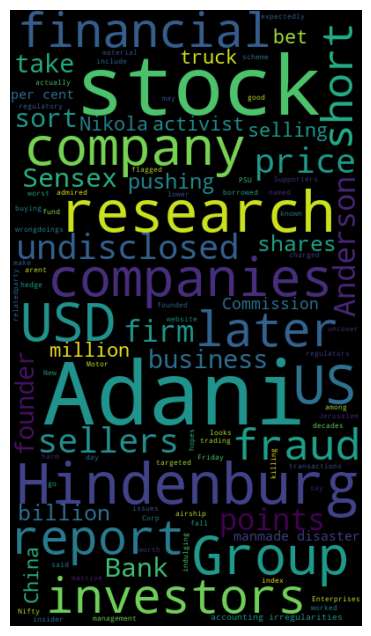

In [147]:
# Word Cloud
txt = ' '.join(text for text in [(df_raw['Article'][0])])
plt.figure(figsize=(15,8))
wordcloud = WordCloud(
    background_color='black',
    max_font_size=100,
    max_words=100,
    height=700
).generate(txt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [166]:
df_raw['Meta_Publisher'].unique()

array(['The Economic Times', 'Times of India', 'Mint', 'Zee Business',
       'The Hindu', 'The Hindu Business Line', 'Financial Times',
       'ThePrint', 'Business Today', 'Telegraph India', 'Onmanorama',
       'Tribune India', 'The Wire', 'Outlook India', 'CNBCTV18.com',
       'India Today', 'Hindustan Times', 'Telangana Today', 'Times Now',
       'Daily Pioneer', 'SwarajyaMag', 'OpIndia', 'Republic', 'Scroll'],
      dtype=object)

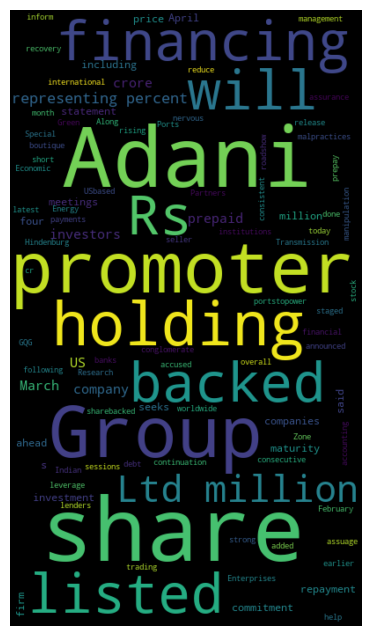

In [183]:
txt = ''.join(text for text in [(df_raw[df_raw['Meta_Publisher'] == 'SwarajyaMag']['Article'][307])])
plt.figure(figsize=(15,8))
wordcloud = WordCloud(
         background_color='black',
         max_font_size=100,
         max_words=100,
         height=700
        ).generate(txt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Analysis & Insights Gathering

### Final Thoughts & Future Work